#  [MegaFon Uplift Competition](https://ods.ai/competitions/megafon-df21-comp)

Результат: Qini коэффициент 0.69 на отложенной выборке

## задача №1: предсказать аплифт по вектору признаков абонента

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split
from catboost import CatBoostClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.metrics import qini_auc_score

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,0,control,-21.671252,-0.621024,-2.842075,-51.831110,129.636266,-285.756326,-61.093746,138.041078,...,-38.413356,-24.451165,56.504067,-0.189278,10.272049,0.212921,75.886788,-110.414462,-16.709625,-0.703765
1,1,control,-34.686034,-1.151992,-22.665072,34.246181,-30.734256,-99.584956,-26.799190,-27.334872,...,-177.776349,8.018468,81.213517,-1.175417,15.345314,0.036785,205.736199,-54.989791,19.713818,-17.718764
2,2,treatment,69.048662,0.474066,9.736740,-25.494699,-9.600274,7.376884,-106.200077,39.657037,...,182.090805,-118.837053,-12.809603,0.398911,-53.774243,-0.586393,921.576204,311.032798,105.630100,0.919092
3,3,control,61.317519,1.296703,-34.345992,-17.611217,-38.021001,41.883604,-1.415220,-39.302033,...,3.848069,258.005558,-362.822718,0.660958,-138.455604,-0.904081,76.344359,57.461948,-289.542387,-37.721344
4,4,control,-76.204820,0.438070,-15.165489,-10.042479,22.548630,129.314238,71.800088,-125.207403,...,-207.931337,42.154019,-292.070142,-0.098644,66.842454,-1.072092,-1066.343927,-50.823453,-53.219431,-25.482573


### cразу увидим, что в тесте для решения задачи у нас присутствует избыточная информация - факт коммуникации с абонентом. Эта информация не поможет нам решить задачу предсказания аплифта, но она поможет максимизировать Qini коэффициент, по которому производится оценка решения. Поэтому: 

## задача №2: использовать в тесте информацию о факте коммуникации с абонентом для того, чтобы увеличить Qini коэффициент

---

# Решение задачи №1

### 1) Conditional Independence Assumption:

интуиция: проверяем, что тритмент действительно раздавали случайно

In [4]:
random_search = GridSearchCV(estimator= CatBoostClassifier(random_state=42, thread_count=-1, verbose=0),
                             param_grid= {},
                             scoring= 'f1_micro', 
                             cv= 3)
random_search.fit(train.loc[:, ~train.columns.isin(['treatment_group','conversion'])], train['treatment_group'])
random_search.best_score_

0.49986500000000006

на основе признаков абонента классификатор допускает в среднем ошибки первого и второго рода так же часто (50%), как и угадывает верный ответ. Значит, коммуникация производилась действительно случайным образом.

### 2) Обучим одну модель с признаком коммуникации (подход S-Learner) ([ссылка на туториал](https://habr.com/ru/company/ru_mts/blog/485980/))

интуиция: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомый uplift.

In [5]:
train.treatment_group = train.treatment_group.map(lambda x: 0 if x == 'control' else 1)

stratify_cols = pd.concat([train.treatment_group, train.conversion], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    train.drop(['treatment_group', 'conversion'],axis=1),
    train.treatment_group,
    train.conversion,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

estimator = CatBoostClassifier(
                                random_state=42,
                                thread_count=-1,
                                verbose=0
                            )
slearner = SoloModel(estimator=estimator)
slearner.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

uplift_from_slearner = slearner.predict(X_val)

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.2460'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

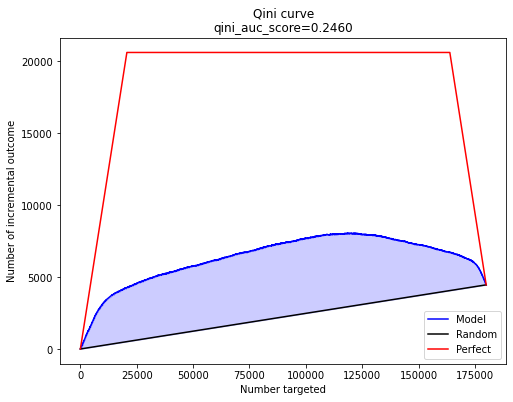

In [6]:
plot_qini_curve(y_val, uplift_from_slearner, trmnt_val, perfect=True)

In [7]:
qini_auc_score(y_val, uplift_from_slearner, trmnt_val)

0.24602170410125218

---

# Решение задачи №2

### 1) Формула построения кривой Qini ([ссылка на туториал](https://habr.com/ru/company/ru_mts/blog/538934/)) :

\begin{equation}qini\ curve (t) = Y^T_t - \frac{Y^C_t N^T_t}{N^C_t} \\ Y^T_t, Y^C_t - таргет\ в\ treatment\ группе, таргет\ в\ control\ группе \\ N^T_t, N^C_t - размер\ treatment\ группы, размер\ control\ группы \end{equation}

Это кумулятивная функция, аргумент которой принимает значения от индекса первого элемента до последнего в датасете, отсортированном по убыванию предсказанного uplift. <br><b>Воспользуемся этим свойством:</b> нам выгодно, чтобы сначала шли элементы строго из treatment группы, а потом уже - элементы из control группы. Тогда кривая резко пойдёт вверх и гарантированно не будет убывать до тех пор, пока не начнутся абоненты из control.
<br>Для этого вручную, без моделей, присвоим высокое значение uplift всем абонентам из treatment и низкое - всем из control.

In [8]:
stratify_cols = pd.concat([train.treatment_group, train.conversion], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    train.drop(['treatment_group', 'conversion'],axis=1),
    train.treatment_group,
    train.conversion,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

uplift_from_hack = [1 if x == 1 else -1 for x in trmnt_val]

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.5577'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

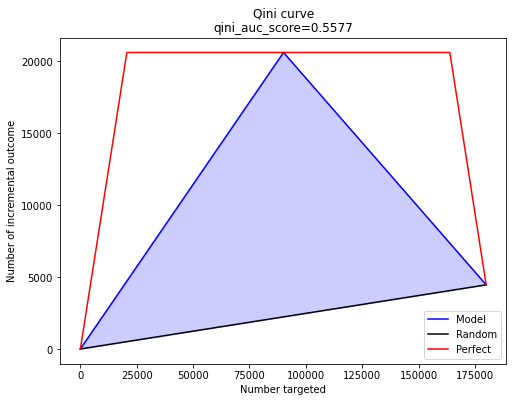

In [9]:
plot_qini_curve(y_val, uplift_from_hack, trmnt_val, perfect=True)

In [10]:
qini_auc_score(y_val, uplift_from_hack, trmnt_val)

0.5577109810450005

### 2) Комбинирование информации о коммуникации и предиктора конверсии

В группе treatment есть как абоненты с истинным значением конверсии Y == 1, так и абоненты с Y==0. То же самое - в группе control. Согласно формуле кривой, нам выгодно, чтобы пользователи были отранжированы по предсказанному uplift в следующем порядке: <li>Абоненты из группы treatment с Y == 1 </li><li>Абоненты из группы treatment с Y == 0 </li><li>Абоненты из группы control с Y == 0 </li><li>Абоненты из группы control с Y == 1 </li> 
<br>Тогда кривая наберёт высоту ещё быстрее, чем в предыдущем подходе, и гарантированно не будет убывать до тех пор, пока не начнутся абоненты из control с Y==1.
<br>Для этого присвоим вручную 4 значения uplift в зависимости от группы treatment/control и от полученного предсказания Y (т.е. conversion) по вектору признаков абонента (X,treatment_group) (колонка treatment_group, разумеется, поможет предсказать Y). Первым делом обучим такую модель:

In [11]:
stratify_cols = pd.concat([train.treatment_group, train.conversion], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    train.drop(['conversion'],axis=1),
    train.conversion,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

model = CatBoostClassifier(
                                random_state=42,
                                thread_count=-1,
                                verbose=0
                            )
model.fit(X_train, y_train)
X_val['y_predict'] = model.predict(X_val)

uplift_from_hack_and_model = X_val[['treatment_group', 'y_predict']].apply(lambda x: 1 if (x.treatment_group == 1)&(x.y_predict == 1) 
                                                                                       else (0.5  if (x.treatment_group == 1)&(x.y_predict == 0)
                                                                                       else (-0.5  if (x.treatment_group == 0)&(x.y_predict == 0)
                                                                                       else (-1  if (x.treatment_group == 0)&(x.y_predict == 1) else None)))
                                                                            , axis=1)

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.6902'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

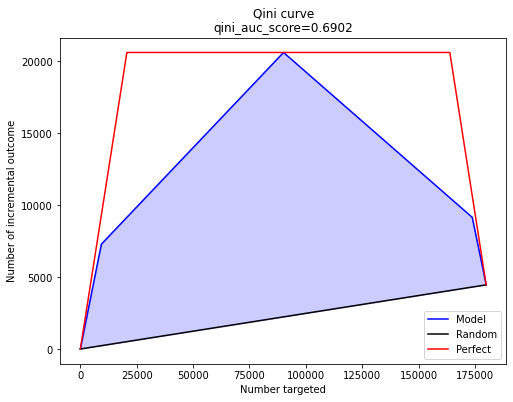

In [12]:
plot_qini_curve(y_val, uplift_from_hack_and_model, X_val['treatment_group'], perfect=True)

In [13]:
qini_auc_score(y_val, uplift_from_hack_and_model, X_val['treatment_group'])

0.690248069129348

---

In [14]:
test.treatment_group = test.treatment_group.map(lambda x: 0 if x == 'control' else 1)

model = CatBoostClassifier(
                                random_state=42,
                                thread_count=-1,
                                verbose=0
                            )
model.fit(train.drop(['conversion'],axis=1), train.conversion)
test['y_predict'] = model.predict(test)
test['pred'] = test[['treatment_group', 'y_predict']].apply(lambda x: 1 if (x.treatment_group == 1)&(x.y_predict == 1) 
                                                                                       else (0.5  if (x.treatment_group == 1)&(x.y_predict == 0)
                                                                                       else (-0.5  if (x.treatment_group == 0)&(x.y_predict == 0)
                                                                                       else (-1  if (x.treatment_group == 0)&(x.y_predict == 1) else None)))
                                                                            , axis=1)
test[['id', 'pred']].to_csv('submit_hack&model.csv', index=False)